# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os
import re
import time

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnull, when, count, isnan, col, countDistinct, udf, concat
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
fpath = 'mini_sparkify_event_data.json'
print(os.path.isfile(fpath))
df = spark.read.json(fpath)
df.show(1)

True
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only 

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.count()

286500

In [6]:
[when(isnull(c) | df[c], c) for c in df.columns]

[Column<b'CASE WHEN ((artist IS NULL) OR artist) THEN artist END'>,
 Column<b'CASE WHEN ((auth IS NULL) OR auth) THEN auth END'>,
 Column<b'CASE WHEN ((firstName IS NULL) OR firstName) THEN firstName END'>,
 Column<b'CASE WHEN ((gender IS NULL) OR gender) THEN gender END'>,
 Column<b'CASE WHEN ((itemInSession IS NULL) OR itemInSession) THEN itemInSession END'>,
 Column<b'CASE WHEN ((lastName IS NULL) OR lastName) THEN lastName END'>,
 Column<b'CASE WHEN ((length IS NULL) OR length) THEN length END'>,
 Column<b'CASE WHEN ((level IS NULL) OR level) THEN level END'>,
 Column<b'CASE WHEN ((location IS NULL) OR location) THEN location END'>,
 Column<b'CASE WHEN ((method IS NULL) OR method) THEN method END'>,
 Column<b'CASE WHEN ((page IS NULL) OR page) THEN page END'>,
 Column<b'CASE WHEN ((registration IS NULL) OR registration) THEN registration END'>,
 Column<b'CASE WHEN ((sessionId IS NULL) OR sessionId) THEN sessionId END'>,
 Column<b'CASE WHEN ((song IS NULL) OR song) THEN song END'>,


In [7]:
df.select([count(when(isnull(c) | (col(c) == ''), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



- 8346 rows are empty in userId field
- Deleting this data will not have a significant effect on the results
  - Without userId, it is diffcult to know this data belongs

In [8]:
df = df.filter(df['userId']!='')

In [9]:
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### First, Divicde Groups, Churn and Not
- Churn users who visited cancellation confirm page
- the other

In [10]:
df.select('userId').distinct().count()

225

In [11]:
df.select('song').distinct().count()

58481

In [12]:
df.select('length').distinct().count()

14866

In [13]:
df.select('artist').distinct().count()

17656

- Check basic information of data
  - There are 225 users
  - 58,481 songs listened to by users
  - These songs have 14,866 kinds of length
  - 17,656 artists are made these songs

In [15]:
churn_user_ids = df.filter(df.page=='Cancellation Confirmation').select('userId').distinct().toPandas()

In [16]:
churn_user_ids.shape

(52, 1)

In [17]:
churn_df = df[df.userId.isin(churn_user_ids['userId'].tolist())]
nonchurn_df = df[df.userId.isin(churn_user_ids['userId'].tolist())==False]

In [18]:
print(f"churn    : {churn_df.count()}")
print(f"non churn: {nonchurn_df.count()}")

churn    : 44864
non churn: 233290


### Second, Explore data to find differences between groups

In [15]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

### Column description
 - artist: singer
 - auth  : user status ( Logged Out / Cancelled / Guest / Logged In)
 - firstName: user first name
 - gender: user gender (M / F)
 - itemInSession: ????
 - lastName: user last name
 - length: song length (may be...)
 - level: Free or paid
 - location: user location
 - method: GET or PUT
 - page: page user visited?
 - registration: user registered datetime
 - sessionId: user session id
 - song: song name
 - status: HTTP return code (200 / 307 / 404)
 - ts: time collected data
 - userAgent: user web agent
 - userId: user id

In [16]:
def extract_os_env(data:str) -> str:
    os_type_mobile = ['iPhone', 'iPad']
    os_type_pc = ['Mac', 'Windows', 'Linux']
    target = re.search(r'\(.*?\)', data)
    if target:
        res = target.group()
        os_type = [os for os in os_type_mobile if res.find(os) != -1]
        if not os_type:
            os_type = [os for os in os_type_pc if res.find(os) != -1]
        os_type = os_type[0]
    else:
        os_type = ''
    return os_type
# extract_os_env = re.search(r'\(.*?\)', useragent_df.iloc[0].userAgent)

In [17]:
convert_udf = udf(lambda x: extract_os_env(x))

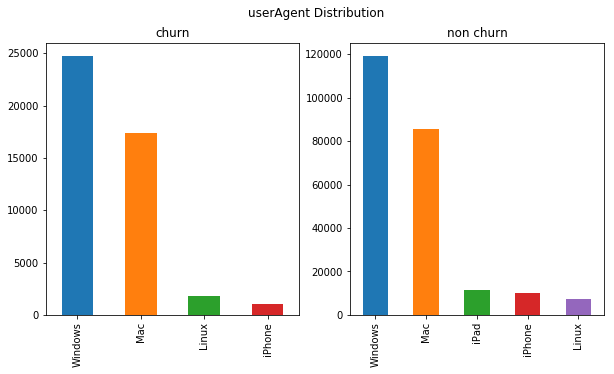

In [18]:
plt.figure(figsize=(10,5))
colname = 'userAgent'
plt.suptitle(f'{colname} Distribution')

plt.subplot(1, 2, 1)
churn_df.toPandas()[colname].apply(lambda x: extract_os_env(x)).value_counts().plot(
    kind='bar',
    title='churn'
)
plt.subplot(1, 2, 2)
nonchurn_df.toPandas()[colname].apply(lambda x: extract_os_env(x)).value_counts().plot(
    kind='bar',
    title='non churn'
)
plt.show()

- get os environment using userAgent

In [19]:
def compare_data(colname:str, axis:int=0, figsize:tuple=(10, 5), topn:int=None, plotkind:str='bar') -> None:
    plt.figure(figsize=figsize)
    plt.suptitle(f'{colname} Distribution')
    if axis==0:
        plt.subplot(1, 2, 1)
        churn_df.toPandas().groupby([colname]).userId.nunique().sort_values(ascending=False)[:topn].plot(
            kind=plotkind,
            title='churn'
        )
        plt.subplot(1, 2, 2)
        nonchurn_df.toPandas().groupby([colname]).userId.nunique().sort_values(ascending=False)[:topn].plot(
            kind=plotkind,
            title='non churn'
        )
    else:
        plt.subplot(2, 1, 1)
        churn_df.toPandas().groupby([colname]).userId.nunique().sort_values(ascending=False)[:topn].plot(
            kind=plotkind,
            title='churn'
        )
        plt.subplot(2, 1, 2)
        nonchurn_df.toPandas().groupby([colname]).userId.nunique().sort_values(ascending=False)[:topn].plot(
            kind=plotkind,
            title='non churn'
        )
    plt.show()

#### Free vs Paid

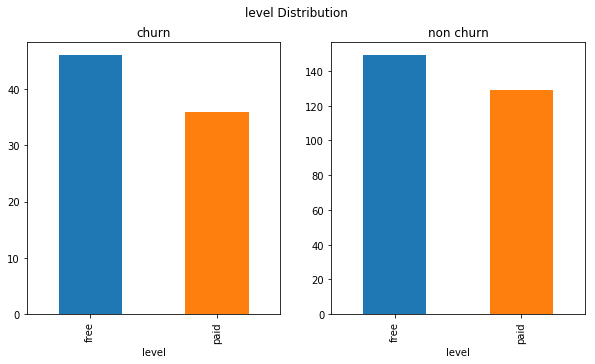

In [20]:
compare_data('level')

- looks like they have similar rate in level
- paid users are more in nonchurn than churn

#### Users each location

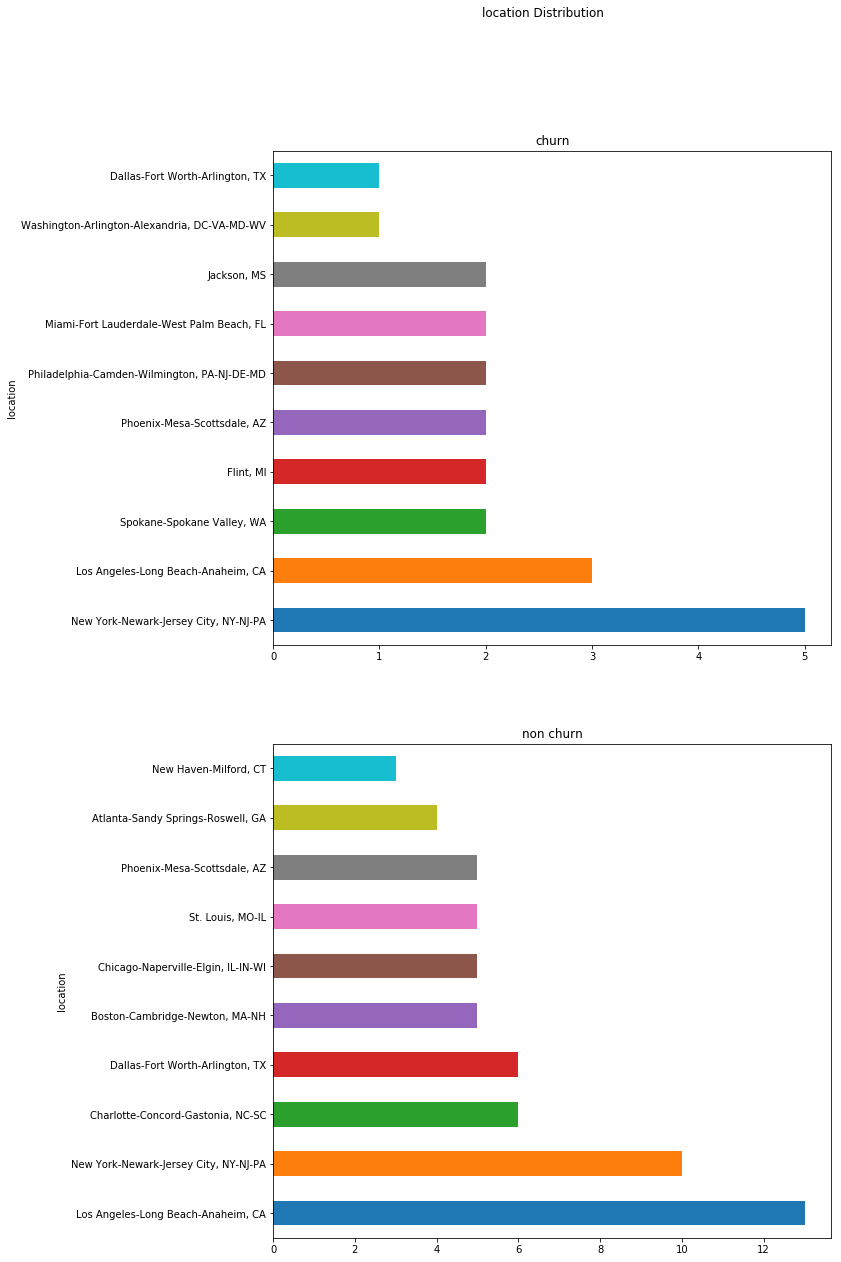

In [21]:
compare_data('location', axis=1, figsize=(10, 20), topn=10, plotkind='barh')

- Location rank is slight different between churn and nonchurn
  - However, is location a important feature to decide churn??

#### HTTP Status

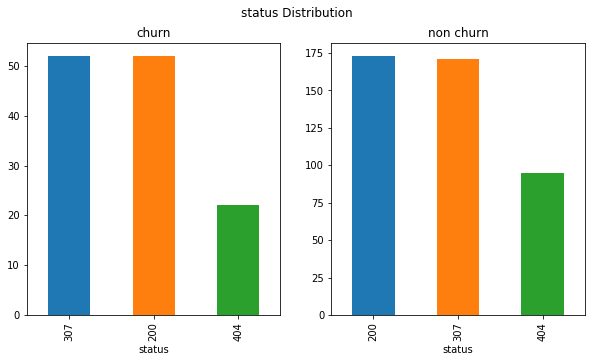

In [22]:
compare_data('status')

- Internet Connection Status may be ciritial reason to decide churn if connection often lost
  - However, users in nonchurn have more exprience 404(Not Found) Error

#### Page

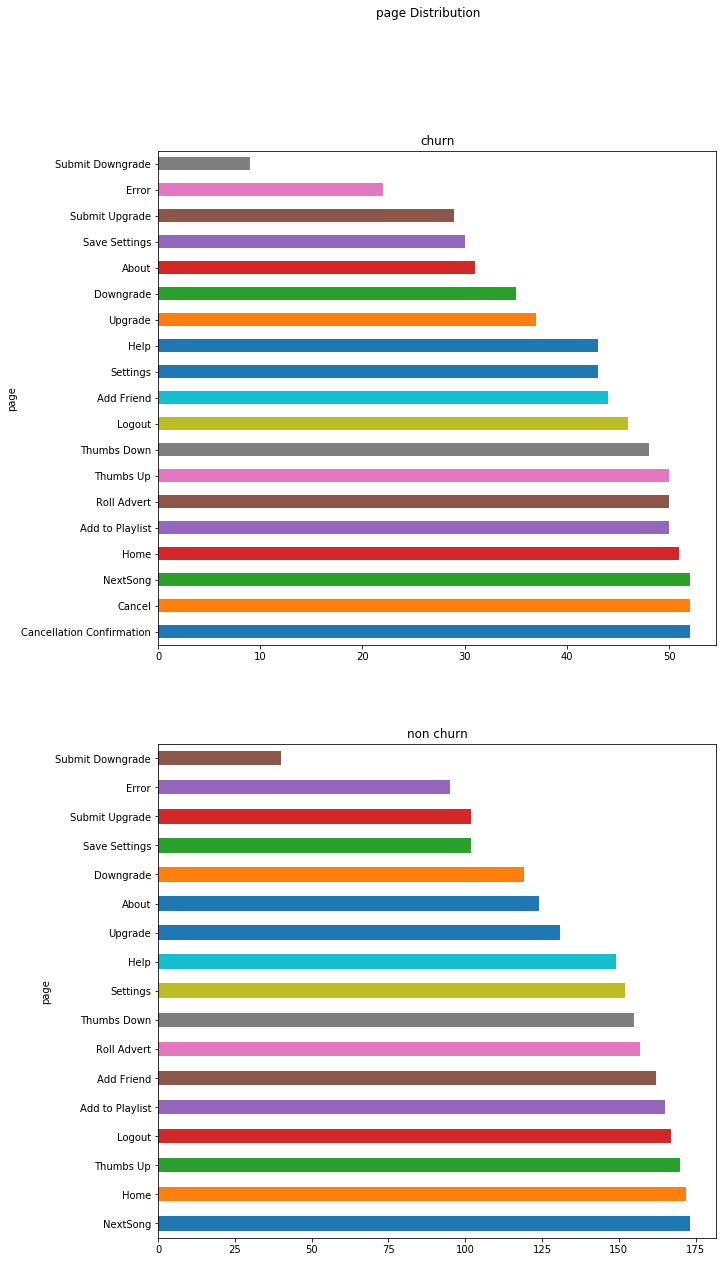

In [23]:
compare_data('page', plotkind='barh', axis=1, figsize=(10, 20))

- this may be important to distinguish churn or not
- becuase they are related with user behavior

#### gender

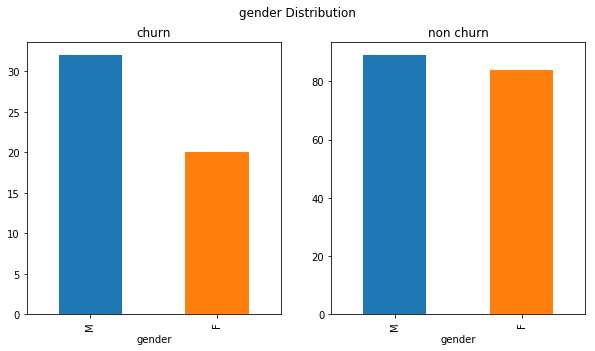

In [24]:
compare_data('gender')

- Gender could be one of important reasons to be churn
  - In churn, Male users is more than female users

#### song length

In [25]:
churn_df.toPandas().length.describe()

count    36394.000000
mean       248.632796
std        102.384977
min          4.048530
25%        199.392200
50%        233.899950
75%        275.630567
max       3024.665670
Name: length, dtype: float64

In [26]:
nonchurn_df.toPandas().length.describe()

count    191714.000000
mean        249.209135
std          98.625883
min           0.783220
25%         199.940770
50%         234.657510
75%         277.158730
max        3024.665670
Name: length, dtype: float64

- very similar, it would not help to decide to choose churn

In [70]:
churn_df.groupby('userId').agg(countDistinct('song')).toPandas().describe()

,count(DISTINCT song)
count,52.000000
mean,638.365385
std,619.598669
min,8.000000
25%,147.000000
50%,432.500000
75%,901.500000
max,2562.000000


In [71]:
nonchurn_df.groupby('userId').agg(countDistinct('song')).toPandas().describe()

,count(DISTINCT song)
count,173.000000
mean,975.768786
std,951.912881
min,3.000000
25%,239.000000
50%,696.000000
75%,1477.000000
max,5946.000000


In [27]:
churn_df.groupby('userId').agg(countDistinct('artist')).toPandas().describe()

,count(DISTINCT artist)
count,52.000000
mean,518.692308
std,455.914317
min,8.000000
25%,143.000000
50%,385.500000
75%,762.250000
max,1804.000000


In [28]:
nonchurn_df.groupby('userId').agg(countDistinct('artist')).toPandas().describe()

,count(DISTINCT artist)
count,173.000000
mean,749.786127
std,633.235440
min,3.000000
25%,226.000000
50%,587.000000
75%,1137.000000
max,3544.000000


- nonchurn users usually listen mucis from various artists than churn

### About Session
min, max, mean
1. ItemInSession per session
2. page per session
3. song per session

**Session each group**

In [29]:
churn_df.groupby('userId').agg(countDistinct('sessionId')).toPandas().describe()

,count(DISTINCT sessionId)
count,52.000000
mean,10.326923
std,8.610803
min,1.000000
25%,5.000000
50%,8.500000
75%,12.000000
max,37.000000


In [30]:
nonchurn_df.groupby('userId').agg(countDistinct('sessionId')).toPandas().describe()

,count(DISTINCT sessionId)
count,173.000000
mean,15.254335
std,15.866963
min,1.000000
25%,6.000000
50%,11.000000
75%,19.000000
max,107.000000


#### listen song each session

In [31]:
churn_df.groupby(['userId', 'sessionId']).agg(count('song')).toPandas().rename(columns={'count(song)': 'song'})['song'].describe()

count    537.000000
mean      67.772812
std       88.168113
min        0.000000
25%       13.000000
50%       38.000000
75%       86.000000
max      708.000000
Name: song, dtype: float64

- Each session, churn and non churn users listen songs similarly

In [33]:
churn_df.groupby(['userId', 'sessionId']).agg(countDistinct('itemInSession'), count('itemInSession')).toPandas().rename(columns={'count(itemInSession)':'itemInSession'})['itemInSession'].describe()

count    537.000000
mean      83.545624
std      104.111389
min        1.000000
25%       18.000000
50%       49.000000
75%      105.000000
max      855.000000
Name: itemInSession, dtype: float64

In [34]:
nonchurn_df.groupby(['userId', 'sessionId']).agg(countDistinct('itemInSession'), count('itemInSession')).toPandas().rename(columns={'count(itemInSession)':'itemInSession'})['itemInSession'].describe()

count    2639.000000
mean       88.400909
std       110.850349
min         1.000000
25%        19.000000
50%        50.000000
75%       113.000000
max      1282.000000
Name: itemInSession, dtype: float64

In [35]:
churn_table = pd.pivot_table(churn_df.toPandas()[['userId', 'sessionId', 'page', 'itemInSession']], values=['itemInSession'], index=['userId', 'sessionId'], columns=['page'], aggfunc=np.mean).fillna(0)

In [36]:
churn_table

itemInSession                                    \
page                     About Add Friend Add to Playlist Cancel   
userId sessionId                                                   
100001 1                   0.0  44.000000       52.000000    0.0   
       46                  0.0   0.000000       70.000000    0.0   
       51                  0.0  20.000000       31.000000    0.0   
       53                  0.0   0.000000        0.000000   22.0   
100003 3                   0.0   0.000000        0.000000    0.0   
       86                  0.0   0.000000       36.000000   80.0   
100005 5                   0.0   9.000000        0.000000    0.0   
       49                  0.0   0.000000        0.000000    0.0   
       72                  0.0  47.000000       53.000000    0.0   
       75                  0.0   0.000000        0.000000    0.0   
       115                 0.0  49.000000       23.500000   72.0   
100006 6                   0.0  29.000000       10.000000   44.0   
100007 34                  0.0  93.000000       43.666667    0.0   
       52                  0.0  42.000000       25.000000    0.0   
       69                  0.0  51.000000        0.000000    0.0   
       127                 0.0   0.000000        7.000000    0.0   
       155                 0.0   0.000000        0.000000    0.0   
       157                 0.0  17.000000        0.000000    0.0   
       182                 0.0   0.000000        0.000000    0.0   
       192                 0.0   0.000000        3.000000    0.0   
       205                 0.0  59.600000       53.333333  200.0   
100009 9                   0.0   0.000000        0.000000    0.0   
       44                  0.0   0.000000        0.000000    0.0   
       64                  0.0   0.000000       19.000000    0.0   
       84                  0.0   0.000000        0.000000    0.0   
       85                185.0  81.250000       86.000000    0.0   
       111                 0.0   0.000000        4.000000    0.0   
       120                 0.0  37.000000       72.666667    0.0   
       126                 0.0   0.000000        0.000000    0.0   
       135                 0.0  29.500000       53.000000    0.0   
...                        ...        ...             ...    ...   
73     391                 0.0   0.000000       23.400000    0.0   
       745                 0.0   8.000000        0.000000    0.0   
       765                 0.0   0.000000        0.000000    0.0   
       1038               85.0  50.000000       86.800000    0.0   
       1059                0.0   0.000000        0.000000   10.0   
87     86                  0.0   0.000000        0.000000    0.0   
       273                 0.0   0.000000        0.000000    0.0   
       300                 0.0   0.000000       11.000000    0.0   
       330                 0.0   0.000000        0.000000    0.0   
       407                 0.0   0.000000        0.000000    0.0   
       423                 0.0   0.000000        0.000000    0.0   
       431                 0.0   0.000000        0.000000    0.0   
       505                 0.0   0.000000        0.000000    0.0   
       593                 0.0   0.000000        0.000000    0.0   
       645                 0.0  49.000000       59.000000    0.0   
       658                 0.0  25.500000        0.000000    0.0   
       704                 0.0   0.000000        9.500000    0.0   
       723                 0.0   0.000000        0.000000    0.0   
       756                 0.0   0.000000       19.500000    0.0   
       778                 0.0   0.000000       14.000000    0.0   
       780                 0.0  31.000000       24.500000    0.0   
       804                 0.0  22.166667       32.666667    0.0   
       835                 0.0  19.000000        0.000000    0.0   
       852                 0.0   0.000000       28.000000    0.0   
       908                 0.0   5.000000       32.000000    0.0   
     

In [37]:
nonchurn_table = pd.pivot_table(nonchurn_df.toPandas()[['userId', 'sessionId', 'page', 'itemInSession']], values=['itemInSession'], index=['userId', 'sessionId'], columns=['page'], aggfunc=np.mean).fillna(0)
nonchurn_table

itemInSession                                                 \
page                     About  Add Friend Add to Playlist   Downgrade  Error   
userId sessionId                                                                
10     9                   0.0   31.333333       63.000000    0.000000    0.0   
       595               442.0  231.800000      180.142857  131.333333    0.0   
       1047                0.0    1.000000        0.000000    0.000000    0.0   
       1414                0.0   59.000000        0.000000   18.000000    0.0   
       1592                0.0    9.000000        0.000000   82.500000    0.0   
       1981                0.0   61.000000       88.000000   98.000000    0.0   
100    256               176.0   93.000000       63.000000    0.000000    0.0   
       369                 0.0   54.000000      106.000000   27.000000    0.0   
       435                 0.0    0.000000       16.000000    0.000000    0.0   
       556               169.0  154.400000      114.500000  120.200000    0.0   
       683                36.0   31.000000       24.000000   34.000000    0.0   
       707               129.5  203.500000      145.200000   37.500000    0.0   
       991                 0.0    0.000000        0.000000    0.000000    0.0   
       1049                3.0   57.000000       36.500000    0.000000    0.0   
       1185                0.0   77.250000       62.500000   33.000000    0.0   
       1210                0.0   67.000000       48.000000   75.000000    0.0   
       1231                0.0    0.000000        0.000000    0.000000    0.0   
       1269                0.0    0.000000        0.000000    0.000000    0.0   
       1279                0.0   11.000000        0.000000    0.000000    0.0   
       1299                3.5    5.500000       80.750000   35.000000    0.0   
       1353                0.0    0.000000        1.000000    0.000000    0.0   
       1382               57.0   39.000000       11.000000    6.000000    0.0   
       1398                0.0   26.500000       20.000000    0.000000    0.0   
       1473                0.0    0.000000      111.000000    0.000000    0.0   
       1505                0.0   45.500000       12.000000    0.000000    0.0   
       1590               96.0  154.000000       96.600000  105.500000  179.0   
       1618                0.0    0.000000       36.000000    0.000000   41.0   
       1678                0.0    0.000000        0.000000    0.000000    0.0   
       1682                0.0    0.000000        0.000000    0.000000    0.0   
       1707                0.0    0.000000        0.000000    0.000000    0.0   
...                        ...         ...             ...         ...    ...   
98     752                 0.0    0.000000        0.000000    0.000000    0.0   
       820                 0.0   27.000000       26.000000    0.000000    0.0   
       925                 0.0    0.000000        6.000000    0.000000    0.0   
       1076                0.0    0.000000        0.000000    0.000000    0.0   
       1139                0.0    0.000000      141.142857  104.000000    3.0   
       1283                0.0   98.000000       52.000000    0.000000    0.0   
       1384                0.0   19.500000        0.000000    0.000000    0.0   
       1696              425.0  217.857143      206.714286  263.333333    0.0   
       1814                0.0   42.333333       41.333333   25.000000    0.0   
       1952                0.0   50.500000       21.000000    0.000000    0.0   
       1965              232.0   58.500000      123.000000   96.000000    0.0   
       2009                0.0  382.375000      246.625000  194.500000    0.0   
       2106                0.0   13.000000       18.000000    0.000000    0.0   
       2131                0.0   93.333333       43.000000   37.666667    0.0   
       2147                0.0    0.000000       97.800000   45.000000    0.0   
       2178                0.0   66.800000      

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
'''
1. itemInSession
2. Page / Session
3. gender
4. # artist / Session
5. # songs / Session
6. level
'''
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [127]:
new_df = df.withColumn('newId', concat('userId', 'sessionId'))

In [128]:
def extract_os_env(data:str) -> str:
    os_type_mobile = ['iPhone', 'iPad']
    os_type_pc = ['Mac', 'Windows', 'Linux']
    target = re.search(r'\(.*?\)', data)
    if target:
        res = target.group()
        os_type = [os for os in os_type_mobile if res.find(os) != -1]
        if not os_type:
            os_type = [os for os in os_type_pc if res.find(os) != -1]
        os_type = os_type[0]
    else:
        os_type = ''
    return os_type
convert_udf = udf(lambda x: extract_os_env(x))

In [129]:
new_df = new_df.withColumn('os', convert_udf('userAgent'))

In [130]:
new_df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', newId='3029', os='Windows')]

In [18]:
new_df.count()

278154

In [19]:
def decide_level(vals:list) -> str:
    if vals[0].lower() == 'free':
        if vals[-1].lower() == 'paid':
            lv = 'free2paid'
        else:
            lv = 'free'
    else:
        if vals[-1] == 'free':
            lv = 'paid2free'
        else:
            lv = 'paid'
    return lv
lv_udf = udf(lambda x: decide_level(x))

In [20]:
def decide_churn(vals:set) -> bool:
    if 'Cancellation Confirmation' in vals or 'Cancel' in vals:
        res = True
    else:
        res = False
    return res
churn_udf = udf(lambda x: decide_churn(x))

In [21]:
item_in_sess = new_df.groupby('newId').agg(F.countDistinct('itemInSession').alias('itemInSession'))
pagecnt_in_sess = new_df[['newId', 'page']].groupby('newId').pivot("page").count().fillna(0)
os_df = new_df.select(['newId', 'os']).groupby('newId').agg(F.collect_set('os')[0].alias('os'))
songs_df = new_df.groupby('newId').agg(count('song').alias('songs'))
artist_df = new_df.groupby('newId').agg(countDistinct('artist').alias('artists'))
gender_df = new_df.groupby('newId').agg(F.collect_set('gender')[0].alias('gender'))
lv_df = new_df.select(['newId', 'level']).groupby('newId').agg(lv_udf(F.collect_list('level')).alias('level'))
churn_df = new_df.select(['newId', 'page']).groupby('newId').agg(churn_udf(F.collect_set('page')).alias('churn'))

In [22]:
selected_df = item_in_sess.join(pagecnt_in_sess, 'newId', 'outer').\
                join(os_df, 'newId', 'outer').\
                join(songs_df, 'newId', 'outer').\
                join(artist_df, 'newId', 'outer').\
                join(gender_df, 'newId', 'outer').\
                join(lv_df, 'newId', 'outer').\
                join(churn_df, 'newId', 'outer')

In [30]:
selected_df.write.mode('overwrite').save('selected_df.json', format='json', header=True)

In [3]:
selected_df = spark.read.json('selected_df.json')

In [ ]:
selected_df.head(1)

In [5]:
selected_df.count()

3175

In [4]:
categorical_cols = ['os', 'level', 'gender']
category_label_dict = {
    category_col: {
        val: str(idx)
        for idx, val in selected_df.select(category_col).distinct().toPandas()[category_col].items()
    }for category_col in categorical_cols
}
category_label_dict

{'os': {'iPad': '0', 'iPhone': '1', 'Linux': '2', 'Mac': '3', 'Windows': '4'},
 'level': {'paid2free': '0', 'free2paid': '1', 'free': '2', 'paid': '3'},
 'gender': {'F': '0', 'M': '1'}}

In [5]:
def label_encoding(col_name):
    tmp_df = selected_df.select(['newId', col_name]).replace(category_label_dict[col_name], subset=col_name)
    return tmp_df
    

In [6]:
encoded_gender = label_encoding('gender')
encoded_os = label_encoding('os')
encoded_level = label_encoding('level')

In [7]:
categorical_features = encoded_gender.join(encoded_os, 'newId', 'inner').\
                                        join(encoded_level, 'newId', 'inner')
categorical_features.show(2)

+--------+------+---+-----+
|   newId|gender| os|level|
+--------+------+---+-----+
|10001935|     1|  2|    2|
|  101813|     1|  4|    3|
+--------+------+---+-----+
only showing top 2 rows



In [8]:
numeric_cols = ['newId', 'itemInSession', 'songs', 'artists', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Up', 'Upgrade']
numeric_features = selected_df.select(numeric_cols)
# numeric_features.show(2)

In [9]:
label = selected_df.select(['newId', 'churn'])

In [10]:
final_df = categorical_features.join(numeric_features, 'newId', 'inner').join(label, 'newId', 'inner')


In [11]:
final_df = final_df.drop('newId')

In [12]:
final_df.show(1)

+------+---+-----+-------------+-----+-------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+---------+-------+-----+
|gender| os|level|itemInSession|songs|artists|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Up|Upgrade|churn|
+------+---+-----+-------------+-----+-------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+---------+-------+-----+
|     1|  2|    2|           28|   19|     19|    1|         2|              1|        0|    0|   1|   1|     1|      19|          1|            0|       0|               0|             0|        0|      0|false|
+------+---+-----+-------------+-----+-------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+-

In [12]:
for col_name in categorical_cols:
    final_df = final_df.withColumn(col_name, final_df[col_name].cast(IntegerType()))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [13]:
assembler = VectorAssembler(inputCols=numeric_cols[1:], outputCol='numerical_features') # added
tmp = assembler.transform(final_df) # added
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='scaled_features') # added
scaler = scaler.fit(tmp) # added
scaled_resut = scaler.transform(tmp) # added
assembler = VectorAssembler(inputCols=['scaled_features'] + categorical_cols, outputCol='features')
final_result = assembler.transform(scaled_resut)
label_string_idx = StringIndexer(inputCol='churn', outputCol='label')
final_data_w_label = label_string_idx.fit(final_result).transform(final_result)

In [14]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [15]:
final_data = final_data_w_label.drop('churn')
train, test = final_data.randomSplit([0.8, 0.2], seed=1)
print(train.count())
print(test.count())

2534
641


In [15]:
def train_model(traindata:object, testdata:object, suffix:str='normal'):
    models = [
        LogisticRegression(maxIter=50, featuresCol='features', labelCol='label'),
        RandomForestClassifier(numTrees=100, featuresCol='features', labelCol='label'),
        LinearSVC(featuresCol='features', labelCol='label'),
        GBTClassifier(featuresCol='features', labelCol='label')
    ]
    all_results = {}
    for model in models:
        print('='*20)
        model_results = {}
        model_name = model.__class__.__name__
        print(model_name)
        start = time.time()
        print(f'train start: {start}')
        model = model.fit(traindata)
        end = time.time()
        print(f'train end: {end}')
        model_results['train'] = f"{end - start:.6f}"
        print(model_results['train'])
        start = time.time()
        print(f'inference start: {start}')
        pred = model.transform(testdata)
        end = time.time()
        print(f'inference end: {end}')
        model_results['inference'] = f"{end - start:.6f}"
        print(model_results['inference'])
        f1_score = evaluator.evaluate(pred, {evaluator.metricName:'f1'})
        precision = evaluator.evaluate(pred, {evaluator.metricName:'weightedPrecision'})
        recall = evaluator.evaluate(pred, {evaluator.metricName:'weightedRecall'})
        print(f1_score)
        model_results['f1'] = f1_score
        model_results['precision'] = precision
        model_results['recall'] = recall
        model_path = f"{model_name}_{suffix}"
        model.write().overwrite().save(model_path)
        all_results[model_name] = model_results
        print('='*20)
    all_results_df = pd.DataFrame(all_results)
    all_results_df.to_csv(f'results_{suffix}.csv')
    return all_results, all_results_df, models

In [17]:
model_result, result_report = train_model(traindata=train, testdata=test, suffix='all')

LogisticRegression
train start: 1635128325.1469765
train end: 1635128346.6987576
21.551781
inference start: 1635128346.6992598
inference end: 1635128346.8276534
0.128394
0.9743332298201449
RandomForestClassifier
train start: 1635128357.6789699
train end: 1635128367.3916457
9.712676
inference start: 1635128367.3920565
inference end: 1635128367.524207
0.132151
0.9743332298201449
LinearSVC
train start: 1635128377.7943108
train end: 1635128506.3359058
128.541595
inference start: 1635128506.3365288
inference end: 1635128506.4425151
0.105986
0.9743332298201449
GBTClassifier
train start: 1635128512.748911
train end: 1635128536.152519
23.403608
inference start: 1635128536.1531048
inference end: 1635128536.2749546
0.121850
0.9759895217800602


In [18]:
result_report

,LogisticRegression,RandomForestClassifier,LinearSVC,GBTClassifier
f1,0.974333,0.974333,0.974333,0.97599
inference,0.128394,0.132151,0.105986,0.121850
precision,0.965973,0.965973,0.965973,0.973155
recall,0.982839,0.982839,0.982839,0.981279
train,21.551781,9.712676,128.541595,23.403608


## With Undersampling
 - to fit churn users' data, use undersampling

In [16]:
churn_size = final_data_w_label.where(final_data_w_label.churn=='true').count()
nonchurn = final_data_w_label.where(final_data_w_label.churn=='false').sample(1.0).limit(churn_size)
churn = final_data_w_label.where(final_data_w_label.churn=='true')
undersampled = churn.union(nonchurn).orderBy(F.rand()) # shuffle
undersampled = undersampled.drop('churn')

In [17]:
train2, test2 = undersampled.randomSplit([0.8, 0.2], seed=1)

In [18]:
model_result2, result_report2, models2 = train_model(traindata=train2, testdata=test2, suffix='undersampling')

LogisticRegression
train start: 1635205333.3303986
train end: 1635205355.5559216
22.225523
inference start: 1635205355.5565128
inference end: 1635205355.6927164
0.136204
0.6178489702517161
RandomForestClassifier
train start: 1635205369.599919
train end: 1635205378.3056722
8.705753
inference start: 1635205378.3062725
inference end: 1635205378.469371
0.163099
0.5738440303657696
LinearSVC
train start: 1635205391.661779
train end: 1635205502.863946
111.202167
inference start: 1635205502.864645
inference end: 1635205502.9738657
0.109221
0.540133779264214
GBTClassifier
train start: 1635205510.3892498
train end: 1635205533.733379
23.344129
inference start: 1635205533.7338903
inference end: 1635205533.8618002
0.127910
0.6134579768939059


In [19]:
result_report2

,LogisticRegression,RandomForestClassifier,LinearSVC,GBTClassifier
f1,0.617849,0.573844,0.540134,0.613458
inference,0.136204,0.163099,0.109221,0.127910
precision,0.647233,0.590635,0.806763,0.620428
recall,0.608696,0.565217,0.565217,0.608696
train,22.225523,8.705753,111.202167,23.344129


## Refinement

In [20]:
clf_GBT = models2[-1]

In [21]:
paramGrid = ParamGridBuilder() \
            .addGrid(clf_GBT.maxDepth, [5, 10]) \
            .addGrid(clf_GBT.maxBins, [16, 32]) \
            .addGrid(clf_GBT.stepSize, [0.11, 0.3]) \
            .addGrid(clf_GBT.maxIter, [10, 100]) \
            .build()
crossval = CrossValidator(estimator=clf_GBT, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=4, parallelism=2)


In [22]:
tuning_gbt = crossval.fit(train2)

In [25]:
best_model = tuning_gbt.bestModel
best_params = {'maxDepth':best_model._java_obj.getMaxDepth(),
               'maxBins':best_model._java_obj.getMaxBins(),
               'maxIter':best_model._java_obj.getMaxIter(),
               'stepSize':best_model._java_obj.getStepSize()}
pred2 = tuning_gbt.transform(test2)
f1_score = evaluator.evaluate(pred2, {evaluator.metricName:'f1'})
precision = evaluator.evaluate(pred2, {evaluator.metricName:'weightedPrecision'})
recall = evaluator.evaluate(pred2, {evaluator.metricName:'weightedRecall'})

print(f1_score)
print(precision)
print(recall)

0.5738440303657696
0.5906354515050167
0.5652173913043479


In [26]:
best_model

GBTClassificationModel (uid=GBTClassifier_aed9c5decc35) with 10 trees

In [27]:
best_params

{'maxDepth': 5, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.11}

In [29]:
tuning_gbt.avgMetrics

[0.6243735967195929,
 0.5932504083137958,
 0.6035040315022016,
 0.6018175451998982,
 0.6792566016457013,
 0.6108099321233196,
 0.6485322073493429,
 0.6222071555895086,
 0.6534271610742199,
 0.6534271610742199,
 0.6534271610742199,
 0.6659998824704707,
 0.6534271610742199,
 0.6534271610742199,
 0.6534271610742199,
 0.6659998824704707]

## Conclusion
This capstone project is a great exercise to apply what I study in this course; data analysis, data cleaning, features selection, machine learning modeling, fine tuning, etc.
Also I love this kind of project which wants us to solve a problem using data of real world
0.97 F1-score for churn prediction using GBTClassifier but every model has similar performance
However, performance score was lower than before with Undersampling. (0.6 f1 score)
Although I got a high score model, worry about models

Stability
- There was a big difference in performance depending on whether or not undersampling was used. Although precision and recall are good, additional confirmation is required by methods such as classification reports   

Small dataset   
- Model was trained on only 225 users' behavior data. Accuracy on new data can fluctuate more than expected although model score is good   

Undersampling   
- This technique can prevent overfitting of the model, but does not learn multiple patterns.   

Although performance is lower when apply undersampling, it would be better after optimizing
This project allowed me to skillfully handle Spark, which I rarely handle.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.